In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import mutagenesis_functions as mf
import time as time

In [2]:
# load hairpin data
data_path = '../../../data_toyhairpin/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

# put in a dictionary for deepomics
train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}



In [3]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    
    layer2 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                        # concat, embedding, variational_normal, variational_softmax, + more
              'num_units': 22,
              'norm': 'batch',          # if removed, automatically adds bias instead
              'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
              'dropout': 0.5,           # if removed, default is no dropout
             }
    
    layer3 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../../results/toyhairpin'
param_path = os.path.join(save_path, 'fullyconnected_1_15')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: dense_0
(?, 22)
layer3: dense_0_batch
(?, 22)
layer4: dense_0_active
(?, 22)
layer5: dense_0_dropout
(?, 22)
layer6: dense_1
(?, 1)
layer7: dense_1_bias
(?, 1)
layer8: output
(?, 1)
----------------------------------------------------------------------------


In [4]:
# initialize session
sess = utils.initialize_session()

In [5]:
#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=20, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- elapsed time=4.74s -- loss=0.32785 -- acc=86.088029%  
 
  valid loss:		0.05555
  valid accuracy:	1.00000+/-0.00000
  valid auc-roc:	1.00000+/-0.00000
  valid auc-pr:		1.00000+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/toyhairpin/fullyconnected_1_15_best.ckpt
Epoch 2 out of 100 
[==============================] 100.0% -- elapsed time=4.81s -- loss=0.12253 -- acc=96.627083%  
 
  valid loss:		0.02890
  valid accuracy:	1.00000+/-0.00000
  valid auc-roc:	1.00000+/-0.00000
  valid auc-pr:		1.00000+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/toyhairpin/fullyconnected_1_15_best.ckpt
Epoch 3 out of 100 
[==============================] 100.0% -- elapsed time=5.03s -- loss=0.09976 -- acc=97.057296%  
 
  valid loss:		0.02196
  valid accuracy:	1.00000+/-0.00000
  valid auc-roc:	1.00000+/-0.00000
  valid auc-pr:		1.00000+/-0.00000
  lower cross-validation found
  sa

In [17]:
sess.close()
sess = utils.initialize_session()

In [7]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../../results/toyhairpin/fullyconnected_1_15_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/toyhairpin/fullyconnected_1_15_best.ckpt
  test  loss:		0.01256
  test  accuracy:	1.00000+/-0.00000
  test  auc-roc:	1.00000+/-0.00000
  test  auc-pr:		1.00000+/-0.00000


## First order mutagenesis saliency

In [8]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


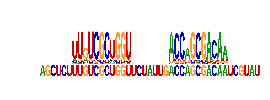

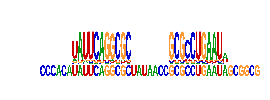

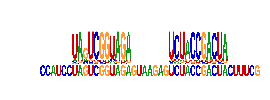

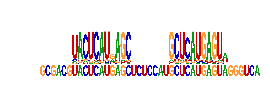

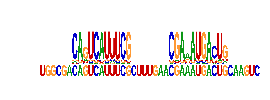

In [9]:
numplots=5

for ii in range(numplots): 

    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    mf.fom_saliency(X, layer='output', alphabet='rna', nntrainer=nntrainer, sess=sess, figsize=(15,1.5))
    

## Second Order Mutagenesis 

In [10]:
savepath = 'Arrays/toyhairpin_FC_1_15_sumoutputs1k.npy'

num_summary = 1000
X = test['inputs'][plot_index[:num_summary]]

sum_mut2 = mf.som_average(X, savepath, nntrainer, sess, progress='off')

----------------Summing complete----------------
Saving scores to Arrays/toyhairpin_FC_1_15_sumoutputs1k.npy


In [11]:
X = test['inputs'][plot_index[:num_summary]]

#Load the saved data
savepath = 'Arrays/toyhairpin_FC_1_15_sumoutputs1k.npy'
sum_mut2 = np.load(savepath)

#average the values
num_summary = 1000
mean_mut2 = sum_mut2/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4
meanhol_mut2 = mean_mut2.reshape(X.shape[1],X.shape[1],4,4)

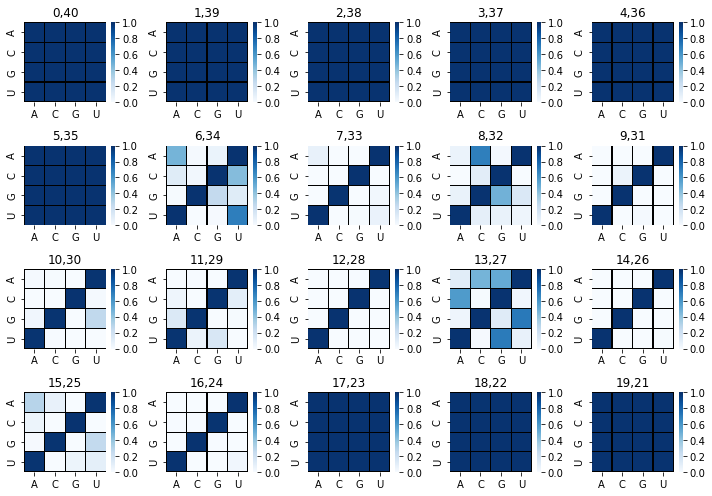

In [12]:
mf.symlinear_holplot(meanhol_mut2, figplot=(4,5), alphabet='rna')

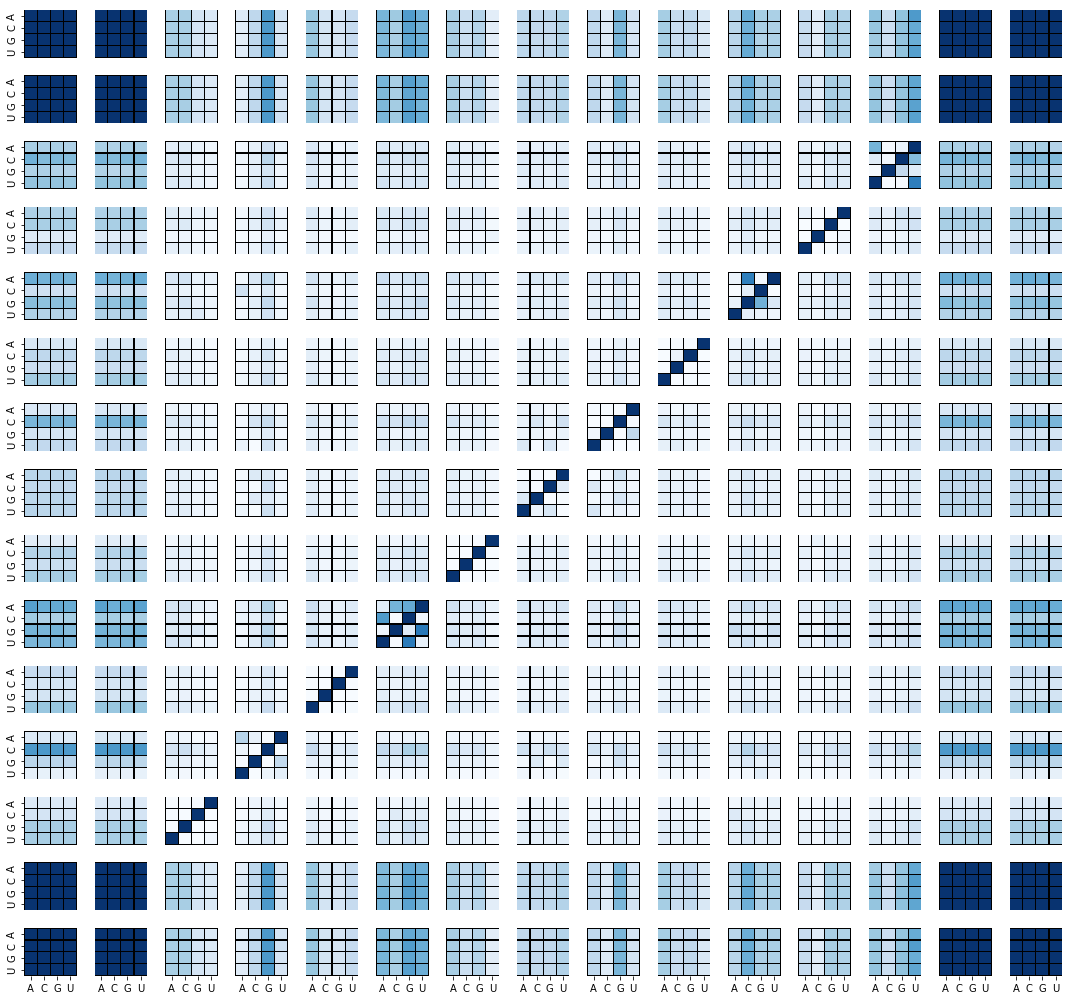

In [13]:
mf.square_holplot(meanhol_mut2, num=15, alphabet='rna')

## Look at Hidden Layers

In [14]:
W = nnmodel.get_parameters(sess, layer='dense_1')[0]
W.shape
top_neurons=np.argsort(np.squeeze(W))[::-1]
top_neurons

array([19,  1,  6,  7, 21, 17,  8,  0, 15,  4, 20, 13, 18, 11, 12,  5, 14,
        2,  9,  3, 10, 16])

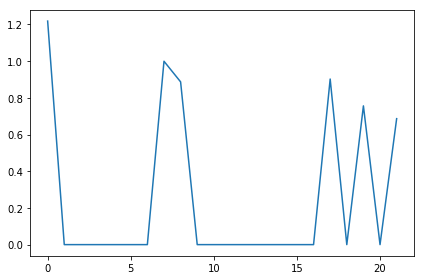

' An example of how a single sequence can excite various different neurons'

In [15]:
dense = nntrainer.get_activations(sess, test, layer='dense_0_active')

#plot which neurons got activated by the highest predicted sequence (from the outputs)
plt.plot(range(dense.shape[1]), dense[plot_index[0]])
plt.show()

''' An example of how a single sequence can excite various different neurons'''



## Look at the dense parameters

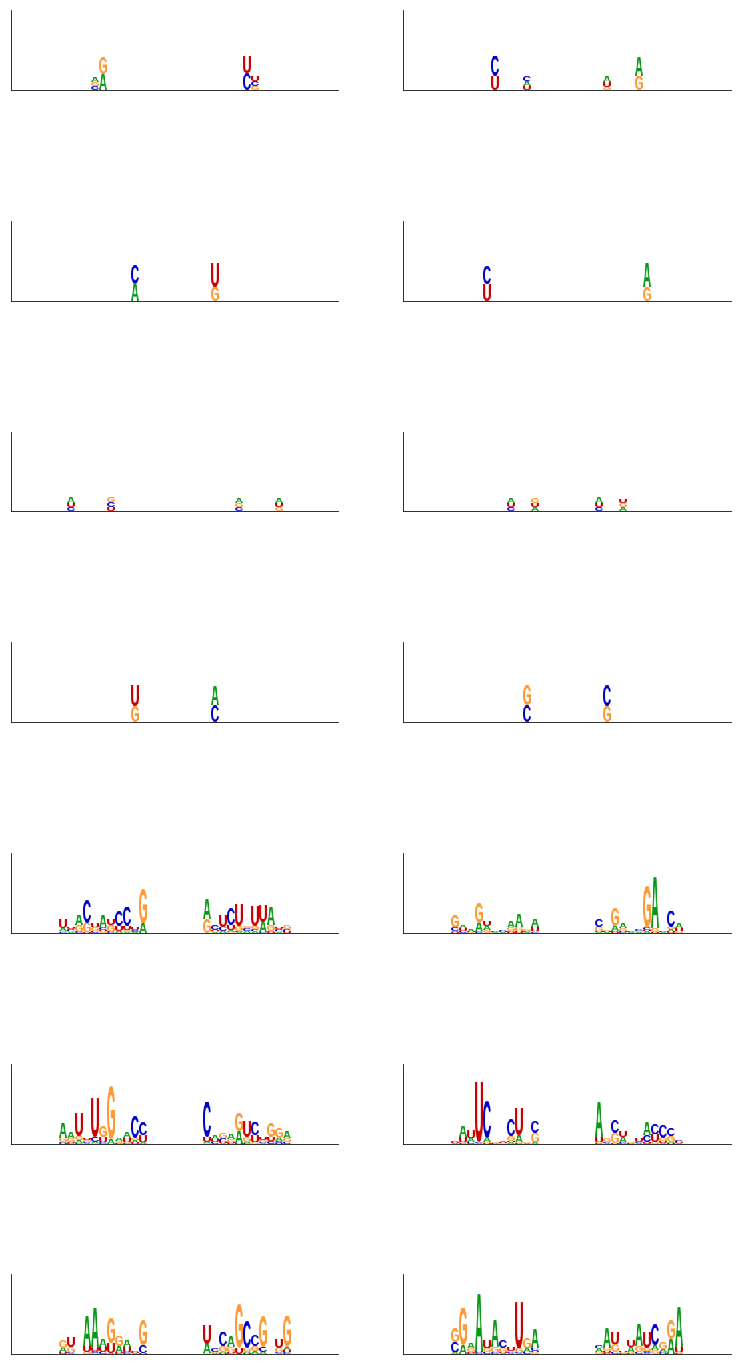

In [16]:
W = nnmodel.get_parameters(sess, layer='dense_0')[0]
W = W.reshape((41,4,dense.shape[1]))
W = np.expand_dims(W, axis=1)

num_plots = 14

Wplot = W[:,:,:,top_neurons[:num_plots]]

fig = visualize.plot_filter_logos(Wplot, figsize=(100,200), height=50,
                                 nt_width=10, norm=0, alphabet='rna', num_rows=num_plots//2)

